In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, ADAM
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import Sampler
from typing import Literal, Union, List, Tuple, Dict, 

algorithm_globals.random_seed = 42

import torch
from qiskit_machine_learning.connectors import TorchConnector
from tqdm import tqdm

In [26]:
def binaryDecomp(n: int) -> list[int] :
    return [int(bit) for bit in bin(n)[2:]]  # Remove the '0b' prefix

In [28]:
class Qubit() :
    def __init__(self, a_: complex, b_: complex) -> None:
        self.a = a_
        self.b = b_

    def squaredNorm(self) -> float:
        return np.abs(self.a)**2 + np.abs(self.b)**2
    
    def norm(self) -> float:
        return np.sqrt(self.squaredNorm())
    
    def normalize(self) -> None:
        norm = self.norm()
        self.a /= norm
        self.b /= norm

class System() :
    """
    multi-qubit system
    """
    def __init__(self, qubits_: list[Qubit] | None, coefficients_ : list[complex] | None) -> None:
        if qubits_ is None:
            self.qubits = None
        else:
            self.qubits = qubits_

        if coefficients_ is not None:
            self.coefficients = coefficients_
        else:
            self.qubitsToCoefficients()

    def qubitsToCoefficients(self) -> None:
        assert self.qubits is not None, "here self.qubits can not be None"
        n = len(self.qubits)
        self.coefficients = []
        for i in range(2**n):
            binary = binaryDecomp(i)
            coeff = 1
            for j in range(n):
                coeff *= self.qubits[j].a if binary[j] == 0 else self.qubits[j].b
            self.coefficients.append(coeff)

In [29]:
def qubitFidelity(q1: Qubit, q2: Qubit) -> float:
    return np.abs(np.dot([q1.a, q1.b], [q2.a, q2.b]))**2

In [2]:
num_inputs = 1 # num of features (p)
num_samples = 30 # num of instances (n)

In [3]:
# Points entre -2 et 2 sur un seul axe
X = 4 * algorithm_globals.random.random([num_samples, 1]) - 2  
# Bleu si entre -1 et 1, rouge sinon
y = np.where((X >= -1) & (X <= 1), 1, -1).flatten() 

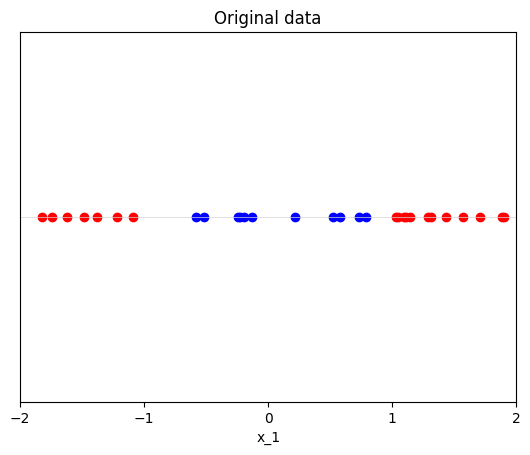

In [4]:
# On plot la distribution
for x_i, y_i in zip(X, y):
    if y_i == 1:
        plt.plot(x_i[0], 0, "bo") 
    else:
        plt.plot(x_i[0], 0, "ro")

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Original data")
plt.xlabel("x_1")
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([])
plt.xlim(-2, 2)
plt.show()

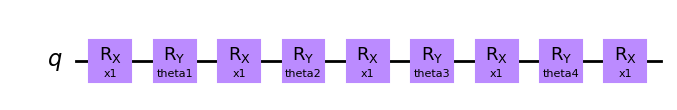

In [5]:
# Le circuit contient 1 input et 4 paramètres à entrainer
params = [Parameter("x1"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3"), Parameter("theta4")]
# Le circuit utilise un seul qubit
qcc = QuantumCircuit(1) 
# On suit l'architecture du papier
qcc.rx(params[0], 0)
qcc.ry(params[1], 0)
qcc.rx(params[0], 0)
qcc.ry(params[2], 0)
qcc.rx(params[0], 0)
qcc.ry(params[3], 0)
qcc.rx(params[0], 0)
qcc.ry(params[4], 0)
qcc.rx(params[0], 0)

qcc.draw("mpl", style="clifford")

In [6]:
# On prépare notre Estimator
estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qcc, 
    estimator=estimator,
    input_params=[params[0]], 
    weight_params=[params[1], params[2], params[3], params[4]],
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [15]:
x = np.array([0.5])
x = torch.tensor(x, dtype=torch.float)

model = TorchConnector(estimator_qnn)

res = model(x)

print(res)

tensor([-0.7667], grad_fn=<_TorchNNFunctionBackward>)


In [18]:
# On prépare notre Estimator
sampler = Sampler()
estimator_qnn = SamplerQNN(
    circuit=qcc, 
    sampler=sampler,
    input_params=[params[0]], 
    weight_params=[params[1], params[2], params[3], params[4]],
)

C:\Users\sandr\AppData\Local\Temp\ipykernel_13552\4294503165.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sandr\AppData\Local\Temp\ipykernel_13552\4294503165.py:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = SamplerQNN(


In [19]:
x = np.array([0.5])
x = torch.tensor(x, dtype=torch.float)

model = TorchConnector(estimator_qnn)

res = model(x)

print(res)

tensor([0.1047, 0.8953], grad_fn=<_TorchNNFunctionBackward>)


In [75]:
# On définit une callback function pour monitorer l'entrainement
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [81]:
# On prépare le classifier avec le circuit à entrainer et l'optimizer
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, 
    optimizer=COBYLA(maxiter=6), 
    callback=callback_graph
)

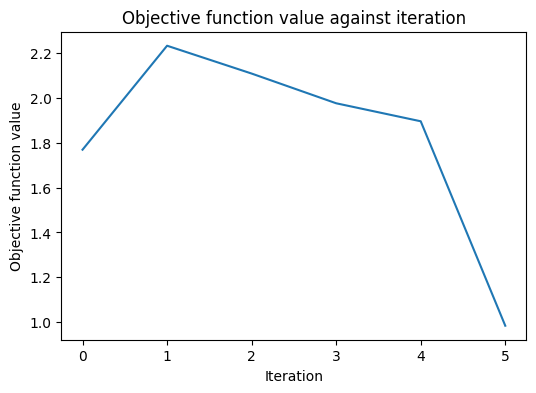

0.7

In [82]:
# On crée un array vide to stocker les valeurs de la loss pendant l'entrainement
objective_func_vals = []
# On fit le modèle aux données
estimator_classifier.fit(X, y)
# On affiche l'accuracy
estimator_classifier.score(X, y)

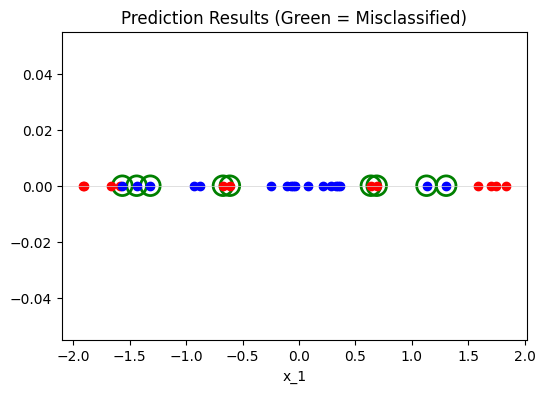

In [84]:
# On génère les valeurs prédites
y_predict = estimator_classifier.predict(X)

# On plot le résultat
# Red circles indicate misclassified points
for x, y_target, y_p in zip(X, y, y_predict):
    if y_p == 1:
        plt.plot(x[0], 0, "bo") 
    else:
        plt.plot(x[0], 0, "ro")
    
    # On entoure les instances mal classifiées en vert
    if y_target != y_p:
        plt.scatter(x[0], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Prediction Results (Green = Misclassified)")
plt.xlabel("x_1")
plt.show()

In [85]:
# On affiche les valeurs des theta_i
estimator_classifier.weights

array([-0.61512483, -0.0938694 ,  0.03895692,  0.72362907])